# ROOT 2D histograms

This notebook gives an example of the definition of a ROOT 2D histogram and the use of various ROOT methods to get details from the histogram on the bin with the largest value.

In [1]:
import ctypes

import matplotlib.pyplot as plt
import numpy as np
import ROOT

Make a 2D histogram and fill it with 2D gaussian data and one obvious hotspot high point. The ROOT `TH2F` constructor has the following form:

```Python
TH2F(
    name,
    title,
    nxbins, xlow, xup,
    nybins, ylow, yup
)
```

The `title` is a "title string" which defines the title of the histogram together with the titles of the axes. The binning `nxbins, xlow, xup` could be 60, -4.0, 4.0, which would mean 60 bins in the x-axis, ranging from -4 to +4. This would imply that each x bin has width ${\frac{4-(-4)}{60}\simeq 0.1333}$. Underflow and overflow bins also exist for each axis (bin 0 and bin N+1), beyond the explicitly specified 60 "normal" bins.

In [2]:
h2 = ROOT.TH2F(
    "h2",
    "Example 2D histogram; x; y",
    60, -4.0, 4.0,
    50, -3.0, 3.0,
)

Fill this histogram with data, specifically a 2D Gaussian and a manually-added high value hotspot. The histogram's `Fill` method is used to add the 2D data points.

In [3]:
# Fill it with something slightly structured: a 2D Gaussian + a hotspot
rng = np.random.default_rng(314)
x   = rng.normal(loc=0.2, scale=1.0, size=50000)
y   = rng.normal(loc=-0.1, scale=0.8, size=50000)

for xi, yi in zip(x, y):
    h2.Fill(float(xi), float(yi))

for _ in range(500):
    h2.Fill(2.0, 1.5)

Plot the histogram using `matplotlib`. This is facilitated by using a few different histogram methods.

The methods `GetNbinsX` and `GetNbinsY` return the number of "normal" bins in the x and y axes (they don't include the overflow bins).

The methods `GetXaxis` and `GetYaxis` return the histogram's `TAxis` axis objects, for the x and y axes respectively, which have properties concerning the axis titles, ranges, labels and bin edges.

The axis method `GetBinLowEdge` simply returns the lower edge coordinate of a specific bin of the axis.

The method `GetBinContent(binx, biny)` returns the actual stored content of a specific bin, specifically the count of that bin and its weight sum.

In [4]:
nx = h2.GetNbinsX()
ny = h2.GetNbinsY()

print(nx)
print(ny)

60
50


In [5]:
# Build arrays of the bin edges (the last one (nx+1) is the low edge of the overflow bin, i.e. the high edge of the last normal bin).
xedges = np.array([h2.GetXaxis().GetBinLowEdge(i) for i in range(1, nx + 2)])
yedges = np.array([h2.GetYaxis().GetBinLowEdge(j) for j in range(1, ny + 2)])

print(f"array of x bin edges:\n{xedges}")

array of x bin edges:
[-4.         -3.86666667 -3.73333333 -3.6        -3.46666667 -3.33333333
 -3.2        -3.06666667 -2.93333333 -2.8        -2.66666667 -2.53333333
 -2.4        -2.26666667 -2.13333333 -2.         -1.86666667 -1.73333333
 -1.6        -1.46666667 -1.33333333 -1.2        -1.06666667 -0.93333333
 -0.8        -0.66666667 -0.53333333 -0.4        -0.26666667 -0.13333333
  0.          0.13333333  0.26666667  0.4         0.53333333  0.66666667
  0.8         0.93333333  1.06666667  1.2         1.33333333  1.46666667
  1.6         1.73333333  1.86666667  2.          2.13333333  2.26666667
  2.4         2.53333333  2.66666667  2.8         2.93333333  3.06666667
  3.2         3.33333333  3.46666667  3.6         3.73333333  3.86666667
  4.        ]


In [6]:
# Make a NumPy 2D array to hold the bin contents of the 2D histogram.
z = np.zeros((ny, nx), dtype=float)
for j in range(1, ny + 1):
    for i in range(1, nx + 1):
        z[j - 1, i - 1] = h2.GetBinContent(i, j)
print(f"length of the array:\n{len(z)}")
print(f"shape of the array:\n{z.shape}")
print(f"the array itself (truncated in printout here):\n{z}")
print(f"contents of bin at row 20, column 10, which corresponds to the 21st y-bin and the 11th x-bin:\n{z[20, 10]}")

length of the array:
50
shape of the array:
(50, 60)
the array itself (truncated in printout here):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
contents of bin at row 20, column 10, which corresponds to the 21st y-bin and the 11th x-bin:
3.0


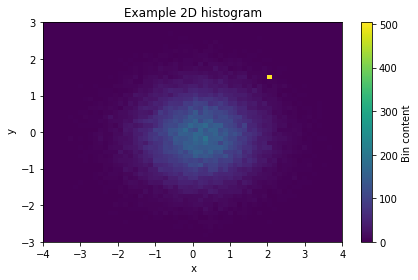

In [7]:
plt.figure()
mesh = plt.pcolormesh(xedges, yedges, z, shading="auto")
plt.xlabel(h2.GetXaxis().GetTitle())
plt.ylabel(h2.GetYaxis().GetTitle())
plt.title(h2.GetTitle())
plt.colorbar(mesh, label="Bin content")
plt.tight_layout()
plt.show()

We can now try to find the bin with the maximum count and see what it contains. In the unique world of ROOT, a 2D histogram is a type of 1D histogram...

The method `GetMaximumBin` (which takes no arguments) returns the bin whose content is largest, and it returns it as an index within a global (flattened) bin index (ROOT flattens the 2D bin indices into one number). The "global" (flattened) bin index in ROOT is a way of mapping a multi-dimensional histogram's bins onto a single linear array. ROOT stores histogram contents in a one-dimensional buffer, even for TH2 and TH3, and the global bin number is the index into that buffer.

The method `GetBinXYZ(global, bx, by, bz)` converts that global index back into a more intuitive (binx, biny, binz) (where binz is typically set to 0/1 for the 2D histogram case).

The method `GetBinContent` returns the actual stored contents of the specified bin. The bin can be specified using the more intuitive (binx, biny) or using the index within the "global" index. So `GetBinContent(binx, biny)` and `GetBinContent(global)` are equivalent, with the latter using the flattened global index.

In [8]:
gmax = h2.GetMaximumBin()
print(f"GetMaximumBin global index: {gmax}")

GetMaximumBin global index: 2402


In [9]:
# Decode the global index of the bin with the largest value into (binx, biny, binz) using GetBinXYZ.
bx, by, bz = ctypes.c_int(0), ctypes.c_int(0), ctypes.c_int(0)
h2.GetBinXYZ(gmax, bx, by, bz)
print("GetBinXYZ(global) -> binx, biny, binz:")
print(bx.value, by.value, bz.value)

GetBinXYZ(global) -> binx, biny, binz:
46 38 0


Aside: In C++, the method is like this: `void TH1::GetBinXYZ(Int_t bin, Int_t& binx, Int_t& biny, Int_t& binz) const;`

Python integers are immutable, so PyROOT cannot "write into" a plain C++ `int`, so mutable C++ integers with `ctypes.c_int` are defined and passed in.

In [10]:
# GetBinContent can be used either with either (binx, biny) or the global index.
content_xy = h2.GetBinContent(bx.value, by.value)
content_global = h2.GetBinContent(gmax)
print(f"GetBinContent(binx, biny): {content_xy}")
print(f"GetBinContent(global): {content_global}")

GetBinContent(binx, biny): 504.0
GetBinContent(global): 504.0


In [11]:
# function to simplify the return of the maximum-bin coordinates and the maximum value
def get_max_bin_2d(hist):
    """
    Return (binx, biny, content) for the maximum-content bin of a TH2.
    """
    bx = ctypes.c_int(0)
    by = ctypes.c_int(0)
    bz = ctypes.c_int(0)
    hist.GetMaximumBin(bx, by, bz)
    content = float(hist.GetBinContent(bx.value, by.value))
    return bx.value, by.value, content

get_max_bin_2d(h2)

(46, 38, 504.0)

In [12]:
max_bx, max_by, max_val = get_max_bin_2d(h2)
print(f"Maximum bin (binx, biny): {(max_bx, max_by)}")
print(f"Maximum value: {max_val}")

Maximum bin (binx, biny): (46, 38)
Maximum value: 504.0
